In [1]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from aero_design_functions import *
from scipy.optimize import fsolve
from lacbox.io import load_pwr, load_ind, load_inds, load_ae, load_pc, load_oper
from lacbox.test import test_data_path
from myteampack import MyHTC
from Our_values import *


8.337868262998404


In [2]:
# data

R = R_Y
r_hub = r_hub
R_X = R_X


scale = (R_Y - r_hub)/(R_X - r_hub)
r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]

chord_root = 5.38  # Chord size at the root [m]
chord_max = 6.3

tsr = 7.2631578947368425
B = 3  # Number of blades [#]

Data_ae = load_ae("DTU_10MW_RWT_ae.dat")
data_ae = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }
abs_t=data_ae["chord"]*data_ae["rel_th"]/100*R_Y/R_X # new thickness
abs_t[0:2]=data_ae["chord"][0:2]
abs_t[2]=0.99*abs_t[2]
t = abs_t # Absolute thickness [m]


cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)

chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)



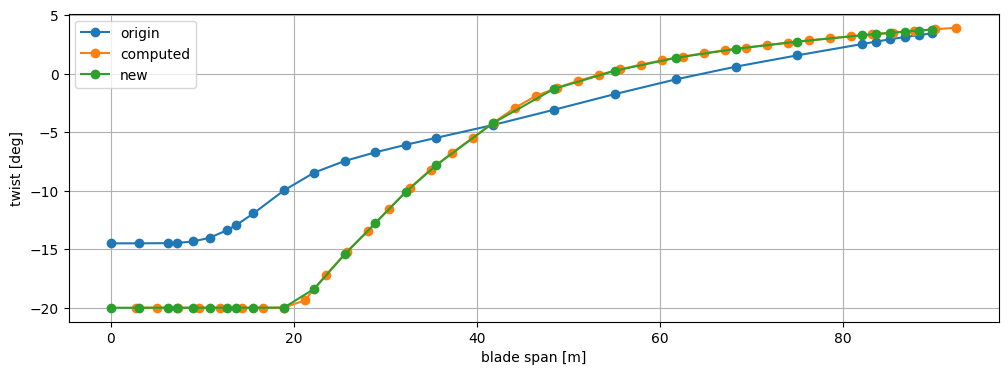

In [3]:
# to modify input hawc file, usefull printing statement


# modifations of _master/Group1_redesign.htc

original_z = np.array([4.44089E-16,
                    3.00000E+00,
                    6.00000E+00,
                    7.00004E+00,
                    8.70051E+00,
                    1.04020E+01,
                    1.22046E+01,
                    1.32065E+01,
                    1.50100E+01,
                    1.82151E+01,
                    2.14178E+01,
                    2.46189E+01,
                    2.78193E+01,
                    3.10194E+01,
                    3.42197E+01,
                    4.02204E+01,
                    4.66217E+01,
                    5.30232E+01,
                    5.94245E+01,
                    6.58255E+01,
                    7.22261E+01,
                    7.90266E+01,
                    8.05267E+01,
                    8.20271E+01,
                    8.35274E+01,
                    8.50277E+01,
                    8.63655E+01])

new_z = original_z*scale

#for element in new_z:
#    print(f"{element:.5E}")

original_twist = np.array([
    -1.45000E+01,
    -1.45000E+01,
    -1.44851E+01,
    -1.44610E+01,
    -1.43388E+01,
    -1.40201E+01,
    -1.33904E+01,
    -1.29371E+01,
    -1.19445E+01,
    -9.98243E+00,
    -8.45147E+00,
    -7.46417E+00,
    -6.72916E+00,
    -6.08842E+00,
    -5.49322E+00,
    -4.39222E+00,
    -3.09315E+00,
    -1.75629E+00,
    -5.00650E-01,
    6.01964E-01,
    1.55560E+00,
    2.51935E+00,
    2.72950E+00,
    2.93201E+00,
    3.11874E+00,
    3.28847E+00,
    3.42796E+00])

new_twist = -np.interp(new_z, r, twist)             # minus sign to be consistent with htc

plt.figure(figsize=(12,4))
plt.plot(new_z, original_twist, marker='o', label='origin')
plt.plot(r, -twist, marker='o', label='computed')
plt.plot(new_z, new_twist, marker='o', label='new')
plt.xlabel('blade span [m]')
plt.ylabel('twist [deg]')
plt.grid()
plt.legend()
plt.show()

#for element in new_twist:
#    print(f"{element:.5E}")


# modifications of data/DTU_10MW_RWT_ae.dat 
new_curve = r - r_hub

#for element in new_curve:
#    print(f"{element:.5E}")

#for element in chord:
#    print(f"{element:.5E}")

#for element in tc:
#    print(f"{element:.5E}")



In [4]:
# compute TSR range for multi wind speed file

V0 = 11.12

TSR_range = np.arange(4,10,0.5)
omega_range = TSR_range * V0 / R_Y * 60 / (2*np.pi)

#for element in omega_range:
#    print(f"{element:.5f}")


# for DTU 10 MW
V_rated_X = 11.4

TSR_range = np.arange(4,10,0.5)
V_rated_X_range = np.array([11.140000,
                            11.141000,
                            11.142000,
                            11.143000,
                            11.144000,
                            11.145000,
                            11.146000,
                            11.147000,
                            11.148000,
                            11.149000,
                            11.150000,
                            11.151000])
omega_range_X = TSR_range * V_rated_X_range/ R_X * 60 / (2*np.pi)

for element in omega_range_X:
    print(f"{element:.6f}")

4.772506
5.369551
5.966704
6.563963
7.161330
7.758803
8.356384
8.954072
9.551867
10.149769
10.747778
11.345895


In [5]:
# compute omega rated

V_rated_Y = 11.122788574520852
R_Y = 92.52423873190985
TSR_opt = 7.2631578947368425

omega_max = TSR_opt * V_rated_Y / R_Y * 60 / (2*np.pi)
print('omega_max', omega_max)

omega_max 8.337868262998404


RUN HAW2s 1ws 

dict_keys(['s_m', 'a', 'ap', 'flow_angle_rad', 'aoa_rad', 'flow_speed_ms', 'Fx_Nm', 'Fy_Nm', 'M_Nmm', 'UX0_m', 'UY0_m', 'UZ0_m', 'twist_rad', 'X_AC0_m', 'Y_AC0_m', 'Z_AC0_m', 'Cl', 'Cd', 'Cm', 'CLp0_rad', 'CDp0_rad', 'CMp0_rad', 'F0', 'F_rad', 'CL_FS0', 'CLFS_rad', 'V_a_ms', 'V_t_ms', 'torsion_rad', 'vx_ms', 'vy_ms', 'chord_m', 'CT', 'CP', 'angle_rad', 'v_1', 'v_2', 'v_3'])


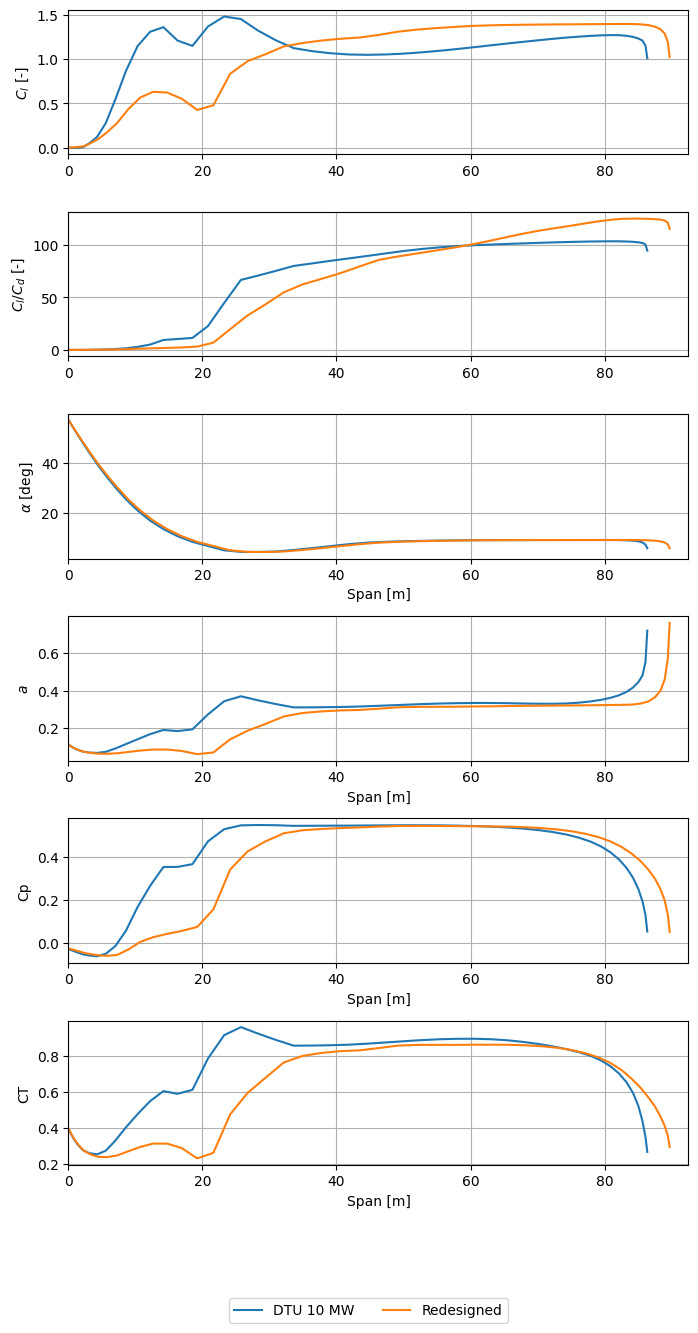

In [6]:

ind_data_path = 'hawc_files/our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind'
ind_data_DTU_10_path = 'hawc_files/dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind'

ind_data = load_ind(ind_data_path)
ind_data_DTU_10 = load_ind(ind_data_DTU_10_path)

# Print the names in the dict
print(ind_data.keys())

alpha_redesign = np.rad2deg(ind_data['aoa_rad'])
Cl_redesign = ind_data['Cl']
Cd_redesign = ind_data['Cd']
CP_redesign = ind_data['CP']
CT_redesign = ind_data['CT']
r_redesign = ind_data["s_m"]

alpha_DTU_10 = np.rad2deg(ind_data['aoa_rad'])
Cl_DTU_10 = ind_data_DTU_10['Cl']
Cd_DTU_10 = ind_data_DTU_10['Cd']
CP_DTU_10 = ind_data_DTU_10['CP']
CT_DTU_10 = ind_data_DTU_10['CT']
r_DTU_10 = ind_data_DTU_10["s_m"]



# Create subplots with increased vertical spacing
fig1, axs1 = plt.subplots(6, 1, num=1, clear=True, figsize=(8, 15))  # Adjust figure size for better spacing
fig1.subplots_adjust(hspace=0.4)  # Increase the space between the plots

# Plot Cl
axs1[0].plot(r_DTU_10, Cl_DTU_10, label='DTU 10 MW')
axs1[0].plot(r_redesign, Cl_redesign, label='Redesigned')
axs1[0].set_ylabel("$C_l$ [-]")
axs1[0].set_xlim(0, R)
axs1[0].grid(True)  # Add grid

# Plot Cl / Cd
axs1[1].plot(r_DTU_10, (Cl_DTU_10 / Cd_DTU_10))
axs1[1].plot(r_redesign, (Cl_redesign / Cd_redesign))
axs1[1].set_ylabel("$C_l / C_d$ [-]")
axs1[1].set_xlim(0, R)
axs1[1].grid(True)  # Add grid

# Plot AoA with label
axs1[2].plot(r_DTU_10, alpha_DTU_10)
axs1[2].plot(r_redesign, alpha_redesign)
axs1[2].set_ylabel(r"$\alpha$ [deg]")
axs1[2].set_xlabel("Span [m]")  # Add label for the last plot
axs1[2].set_xlim(0, R)
axs1[2].grid(True)  # Add grid


axs1[3].plot(r_DTU_10, ind_data_DTU_10["a"])
axs1[3].plot(r_redesign, ind_data["a"])
axs1[3].set_ylabel(r"$a$")
axs1[3].set_xlabel("Span [m]")  # Add label for the last plot
axs1[3].set_xlim(0, R)
axs1[3].grid(True)  # Add grid

axs1[4].plot(r_DTU_10, ind_data_DTU_10["CP"])
axs1[4].plot(r_redesign, ind_data["CP"])
axs1[4].set_ylabel('Cp')
axs1[4].set_xlabel("Span [m]")  # Add label for the last plot
axs1[4].set_xlim(0, R)
axs1[4].grid(True)  # Add grid

axs1[5].plot(r_DTU_10, ind_data_DTU_10["CT"])
axs1[5].plot(r_redesign, ind_data["CT"])
axs1[5].set_ylabel('CT')
axs1[5].set_xlabel("Span [m]")  # Add label for the last plot
axs1[5].set_xlim(0, R)
axs1[5].grid(True)  # Add grid

# Move the legend to the bottom of the figure and apply it to all plots
fig1.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0))

# Show the plot
plt.show()

RUN HAW2s multiws (actually multy TSR, constant speed and changing omega)

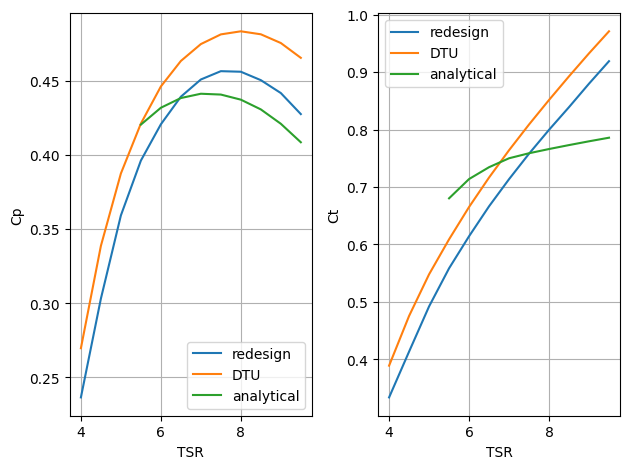

In [21]:
# Side-by-side plots of the power and thrust coefficients calculated with HAWC2S at design pitch versus TSR

pwr_path = "hawc_files/our_design/res_hawc2s/Group1_redesign_hawc2s_multiwsp.pwr"
pwr_data = load_pwr(pwr_path)

pwr_path_DTU_10_MW = "hawc_files/dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_multiwsp.pwr"
pwr_data_DTU_10_MW = load_pwr(pwr_path_DTU_10_MW)


CP_list = []
CT_list = []
TSR = np.arange(5.5,10,0.5)
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)

for tsr in TSR:
    # %% Solving for the a single design
    chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
        r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
    CP_list.append(CP)
    CT_list.append(CT)

CP_array = np.array(CP_list)
CT_array = np.array(CT_list)

fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)

axs1[0].plot(TSR_range, pwr_data["Cp"], label='redesign')
axs1[0].plot(TSR_range, pwr_data_DTU_10_MW["Cp"], label='DTU')
axs1[0].plot(TSR, CP_array, label='analytical')
axs1[0].set_xlabel("TSR")
axs1[0].set_ylabel("CP")
axs1[0].legend()
axs1[0].grid(True)
#axs1[0].set_xlim(min(TSR_range), max(TSR_range))

axs1[1].plot(TSR_range, pwr_data["Ct"], label='redesign')
axs1[1].plot(TSR_range, pwr_data_DTU_10_MW["Ct"], label='DTU')
axs1[1].plot(TSR, CT_array, label='analytical')
axs1[1].set_xlabel("TSR")
axs1[1].set_ylabel("CT")
axs1[1].legend()
axs1[1].grid(True)
#axs1[1].set_xlim(min(TSR_range), max(TSR_range))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


[ 1.56059350e+00  1.56059332e+00  1.56059327e+00  1.56059330e+00
  1.56059328e+00  1.56059328e+00  1.56059328e+00  1.44541969e+00
  1.29687188e+00  1.12521182e+00  2.28718158e-01  9.45085742e-03
 -1.13697627e-02 -5.87381562e-03  1.49698189e-02  1.88055883e-02
 -1.55348376e-02  2.98891127e-02  1.47757195e-03 -1.25729685e-02
  1.97737335e-02 -7.05586190e-03 -6.55807588e-02 -1.48011719e-02
  2.27612826e-02  3.68902668e-02  4.48976144e-03  3.97592403e-01
  5.34068411e-02  6.21111863e-02  4.30197253e-03]
dict_keys(['ws_ms', 'pitch_deg', 'rotor_speed_rpm', 'power_kw', 'thrust_kn'])


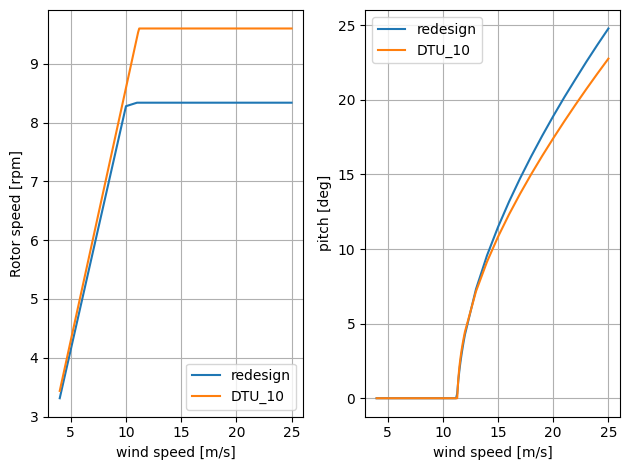

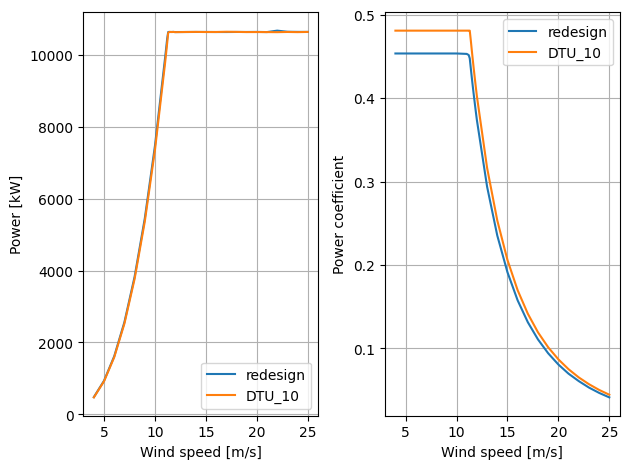

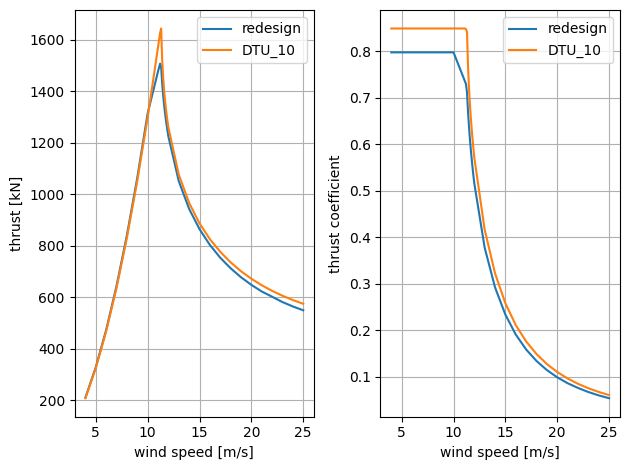

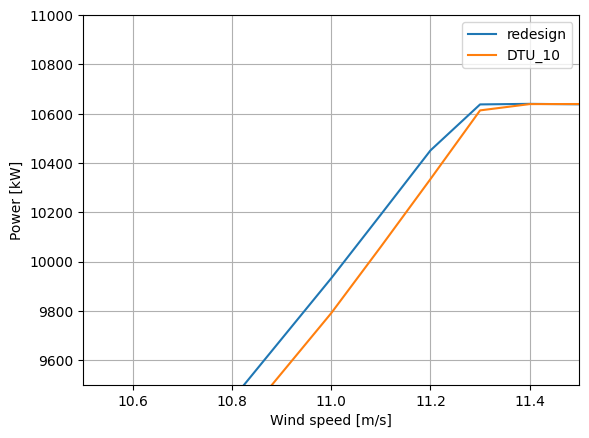

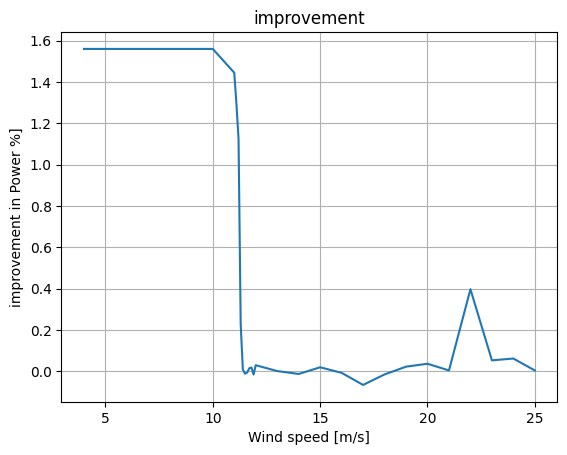

In [8]:
# Side-by-side plots of the rotor speed (left plot) and pitch angles (right plot) versus wind speed

rigid_path = "hawc_files/our_design/data/Group1_redesign_rigid.opt"
rigid_data = load_oper(rigid_path)

rigid_DTU_10_path = "hawc_files/our_design/data/dtu_10mw_rigid.opt"
rigid_DTU_10_data = load_oper(rigid_DTU_10_path)

# power improvement
imp = (rigid_data['power_kw'] - rigid_DTU_10_data['power_kw']) / rigid_DTU_10_data['power_kw']*100
print(imp)


print(rigid_data.keys())


fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)

axs1[0].plot(rigid_data['ws_ms'], rigid_data['rotor_speed_rpm'], label='redesign')
axs1[0].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['rotor_speed_rpm'], label='DTU_10')
axs1[0].set_xlabel("wind speed [m/s]")
axs1[0].set_ylabel("Rotor speed [rpm]")
axs1[0].legend()
axs1[0].grid(True)

axs1[1].plot(rigid_data['ws_ms'], rigid_data['pitch_deg'], label='redesign')
axs1[1].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['pitch_deg'], label='DTU_10')
axs1[1].set_xlabel("wind speed [m/s]")
axs1[1].set_ylabel("pitch [deg]")
axs1[1].legend()
axs1[1].grid(True)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


# Side-by-side plots of the aerodynamic power (left plot) and its coefficient (right plot), and the thrust (left plot) and its coefficient (right plot) versus wind speed

# power and thrust coefficients
# Cp = P / (1/2 * rho * V0**3 * A)
# Ct = T / (1/2 * rho * V0**2 * A)
rho = 1.225
CP_redesign = rigid_data['power_kw'] / (0.5 * rho * rigid_data['ws_ms']**3 * np.pi*R_Y**2)*1e3
CP_DTU_10 = rigid_DTU_10_data['power_kw'] / (0.5 * rho * rigid_DTU_10_data['ws_ms']**3 * np.pi*R_X**2)*1e3

CT_redesign = rigid_data['thrust_kn'] / (0.5 * rho * rigid_data['ws_ms']**2 * np.pi*R_Y**2)*1e3
CT_DTU_10 = rigid_DTU_10_data['thrust_kn'] / (0.5 * rho * rigid_DTU_10_data['ws_ms']**2 * np.pi*R_X**2)*1e3


fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)

axs1[0].plot(rigid_data['ws_ms'], rigid_data['power_kw'], label='redesign')
axs1[0].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['power_kw'], label='DTU_10')
axs1[0].set_ylabel("Power [kW]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].legend()
axs1[0].grid(True)

axs1[1].plot(rigid_data['ws_ms'], CP_redesign, label='redesign')
axs1[1].plot(rigid_DTU_10_data['ws_ms'], CP_DTU_10, label='DTU_10')
axs1[1].set_ylabel("Power coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].legend()
axs1[1].grid(True)


# Adjust layout and show the figure
plt.tight_layout()
plt.show()


fig1, axs1 = plt.subplots(1, 2, num=2, clear=True)

axs1[0].plot(rigid_data['ws_ms'], rigid_data['thrust_kn'], label='redesign')
axs1[0].plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['thrust_kn'], label='DTU_10')
axs1[0].set_xlabel("wind speed [m/s]")
axs1[0].set_ylabel("thrust [kN]")
axs1[0].legend()
axs1[0].grid(True)

axs1[1].plot(rigid_data['ws_ms'], CT_redesign, label='redesign')
axs1[1].plot(rigid_DTU_10_data['ws_ms'], CT_DTU_10, label='DTU_10')
axs1[1].set_xlabel("wind speed [m/s]")
axs1[1].set_ylabel("thrust coefficient")
axs1[1].legend()
axs1[1].grid(True)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(rigid_data['ws_ms'], rigid_data['power_kw'], label='redesign')
plt.plot(rigid_DTU_10_data['ws_ms'], rigid_DTU_10_data['power_kw'], label='DTU_10')
plt.ylabel("Power [kW]")
plt.xlabel("Wind speed [m/s]")
plt.legend()
plt.grid(True)
plt.xlim(10.5,11.5)
plt.ylim(9500,11000)
plt.show()


plt.figure()
plt.title('improvement')
plt.plot(rigid_data['ws_ms'], imp)
plt.ylabel("improvement in Power %]")
plt.xlabel("Wind speed [m/s]")
plt.grid(True)
plt.show()